In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.dataprocessing import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm






# Import des données 

In [124]:
train = pd.read_csv("data/modifie/trainFinal.csv")
display(train)

test = pd.read_csv("data/modifie/testFinal.csv")
display(test)

,date,store_nbr,family,sales,onpromotion,city,state,flagHoliday,transactions,dcoilwtico,type,cluster,jour,mois,annee,jourSemaine,jourAnnee,semaineAnnee
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,1,NaN,93.12,D,13,1,1,2013,1,1,1
1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,1,NaN,93.12,D,13,1,1,2013,1,1,1
2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,1,NaN,93.12,D,13,1,1,2013,1,1,1
3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,1,NaN,93.12,D,13,1,1,2013,1,1,1
4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,1,NaN,93.12,D,13,1,1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,0,2155.0,47.57,B,6,15,8,2017,1,227,33
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,0,2155.0,47.57,B,6,15,8,2017,1,227,33
3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,0,2155.0,47.57,B,6,15,8,2017,1,227,33
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,0,2155.0,47.57,B,6,15,8,2017,1,227,33


,date,store_nbr,family,onpromotion,sales,city,state,flagHoliday,transactions,dcoilwtico,type,cluster,jour,mois,annee,jourSemaine,jourAnnee,semaineAnnee
0,2017-08-16,1,AUTOMOTIVE,0,NaN,Quito,Pichincha,0,NaN,46.80,D,13,16,8,2017,2,228,33
1,2017-08-16,1,BABY CARE,0,NaN,Quito,Pichincha,0,NaN,46.80,D,13,16,8,2017,2,228,33
2,2017-08-16,1,BEAUTY,2,NaN,Quito,Pichincha,0,NaN,46.80,D,13,16,8,2017,2,228,33
3,2017-08-16,1,BEVERAGES,20,NaN,Quito,Pichincha,0,NaN,46.80,D,13,16,8,2017,2,228,33
4,2017-08-16,1,BOOKS,0,NaN,Quito,Pichincha,0,NaN,46.80,D,13,16,8,2017,2,228,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,POULTRY,1,NaN,Quito,Pichincha,0,NaN,47.26,B,6,31,8,2017,3,243,35
28508,2017-08-31,9,PREPARED FOODS,0,NaN,Quito,Pichincha,0,NaN,47.26,B,6,31,8,2017,3,243,35
28509,2017-08-31,9,PRODUCE,1,NaN,Quito,Pichincha,0,NaN,47.26,B,6,31,8,2017,3,243,35
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,NaN,Quito,Pichincha,0,NaN,47.26,B,6,31,8,2017,3,243,35


In [125]:
col = ['family','city','state','type','jour','mois','annee','jourSemaine','jourAnnee','semaineAnnee']
for c in col :
    test['%sCat' % c] = test[c].astype('category').cat.codes
    train['%sCat' % c] = train[c].astype('category').cat.codes

test = test.drop(col, axis=1).copy()    
train = train.drop(col, axis=1).copy()
display(test)
display(train)



,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2017-08-16,1,0,NaN,0,NaN,46.80,13,0,18,12,3,0,0,0,2,0,0
1,2017-08-16,1,0,NaN,0,NaN,46.80,13,1,18,12,3,0,0,0,2,0,0
2,2017-08-16,1,2,NaN,0,NaN,46.80,13,2,18,12,3,0,0,0,2,0,0
3,2017-08-16,1,20,NaN,0,NaN,46.80,13,3,18,12,3,0,0,0,2,0,0
4,2017-08-16,1,0,NaN,0,NaN,46.80,13,4,18,12,3,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,1,NaN,0,NaN,47.26,6,28,18,12,1,15,0,0,3,15,2
28508,2017-08-31,9,0,NaN,0,NaN,47.26,6,29,18,12,1,15,0,0,3,15,2
28509,2017-08-31,9,1,NaN,0,NaN,47.26,6,30,18,12,1,15,0,0,3,15,2
28510,2017-08-31,9,9,NaN,0,NaN,47.26,6,31,18,12,1,15,0,0,3,15,2


,date,store_nbr,sales,onpromotion,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2013-01-01,1,0.000,0,1,NaN,93.12,13,0,18,12,3,0,0,0,1,0,0
1,2013-01-01,1,0.000,0,1,NaN,93.12,13,1,18,12,3,0,0,0,1,0,0
2,2013-01-01,1,0.000,0,1,NaN,93.12,13,2,18,12,3,0,0,0,1,0,0
3,2013-01-01,1,0.000,0,1,NaN,93.12,13,3,18,12,3,0,0,0,1,0,0
4,2013-01-01,1,0.000,0,1,NaN,93.12,13,4,18,12,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,438.133,0,0,2155.0,47.57,6,28,18,12,1,14,7,4,1,226,32
3000884,2017-08-15,9,154.553,1,0,2155.0,47.57,6,29,18,12,1,14,7,4,1,226,32
3000885,2017-08-15,9,2419.729,148,0,2155.0,47.57,6,30,18,12,1,14,7,4,1,226,32
3000886,2017-08-15,9,121.000,8,0,2155.0,47.57,6,31,18,12,1,14,7,4,1,226,32


In [6]:
df = pd.concat([train,test]).drop_duplicates()


## On groupe nos données selon la famille produit et le magasin

In [5]:
display(df)

,date,store_nbr,sales,onpromotion,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2013-01-01,1,0.0,0,1,NaN,93.12,13,0,18,12,3,0,0,0,1,0,0
1,2013-01-01,1,0.0,0,1,NaN,93.12,13,1,18,12,3,0,0,0,1,0,0
2,2013-01-01,1,0.0,0,1,NaN,93.12,13,2,18,12,3,0,0,0,1,0,0
3,2013-01-01,1,0.0,0,1,NaN,93.12,13,3,18,12,3,0,0,0,1,0,0
4,2013-01-01,1,0.0,0,1,NaN,93.12,13,4,18,12,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,NaN,1,0,NaN,47.26,6,28,18,12,1,15,0,0,3,15,2
28508,2017-08-31,9,NaN,0,0,NaN,47.26,6,29,18,12,1,15,0,0,3,15,2
28509,2017-08-31,9,NaN,1,0,NaN,47.26,6,30,18,12,1,15,0,0,3,15,2
28510,2017-08-31,9,NaN,9,0,NaN,47.26,6,31,18,12,1,15,0,0,3,15,2


In [70]:
familyCatListe = df.family.unique()

familyDico = {}

for family in tqdm(familyCatListe):
    dfFam = df.loc[df['family'] == family]
    #    dfFam = df.loc[df['familyCat'] == family]


    listeFamilyDico = TimeSeries.from_group_dataframe(
                                dfFam,
                                time_col="date",
                                group_cols=["store_nbr","family"], # columns for grouping time series
        #                                group_cols=["store_nbr","familyCat"], # columns for grouping time series
#                                static_cols=['onpromotion','flagHoliday','transactions','dcoilwtico','cluster','cityCat','stateCat','typeCat','jourCat','moisCat','anneeCat','jourSemaineCat','jourAnneeCat','semaineAnneeCat'], # variables explicatives (covariates)

                                static_cols=['onpromotion','flagHoliday','transactions','dcoilwtico','cluster','city','state','type','jour','mois','annee','jourSemaine','jourAnnee','semaineAnnee'], # variables explicatives (covariates)
                                value_cols="sales", # variable expliquée (target),
                                fill_missing_dates=True, # filling missing dates, remember Dec 25th
                                freq='D' # jour
                                )
    for ts in listeFamilyDico:
            ts = ts.astype(np.float32)

    listeFamilyDico = sorted(familyDico, key=lambda ts: int(ts.static_covariates_values()[0,0]))
    familyDico[family] = listeFamilyDico

  0%|          | 0/33 [00:00<?, ?it/s]ValueError: Encountered more than one unique value in group             store_nbr      family  onpromotion  flagHoliday  transactions  \
date                                                                        
2013-01-01          1  AUTOMOTIVE            0            1           NaN   
2013-01-02          1  AUTOMOTIVE            0            0        2111.0   
2013-01-03          1  AUTOMOTIVE            0            0        1833.0   
2013-01-04          1  AUTOMOTIVE            0            0        1863.0   
2013-01-05          1  AUTOMOTIVE            0            1        1509.0   
...               ...         ...          ...          ...           ...   
2017-08-27          1  AUTOMOTIVE            0            0           NaN   
2017-08-28          1  AUTOMOTIVE            0            0           NaN   
2017-08-29          1  AUTOMOTIVE            0            0           NaN   
2017-08-30          1  AUTOMOTIVE            0         

ValueError: Encountered more than one unique value in group             store_nbr      family  onpromotion  flagHoliday  transactions  \
date                                                                        
2013-01-01          1  AUTOMOTIVE            0            1           NaN   
2013-01-02          1  AUTOMOTIVE            0            0        2111.0   
2013-01-03          1  AUTOMOTIVE            0            0        1833.0   
2013-01-04          1  AUTOMOTIVE            0            0        1863.0   
2013-01-05          1  AUTOMOTIVE            0            1        1509.0   
...               ...         ...          ...          ...           ...   
2017-08-27          1  AUTOMOTIVE            0            0           NaN   
2017-08-28          1  AUTOMOTIVE            0            0           NaN   
2017-08-29          1  AUTOMOTIVE            0            0           NaN   
2017-08-30          1  AUTOMOTIVE            0            0           NaN   
2017-08-31          1  AUTOMOTIVE            0            0           NaN   

            dcoilwtico  cluster   city      state type  jour  mois  annee  \
date                                                                        
2013-01-01   93.120000       13  Quito  Pichincha    D     1     1   2013   
2013-01-02   93.140000       13  Quito  Pichincha    D     1     1   2013   
2013-01-03   92.970000       13  Quito  Pichincha    D     1     1   2013   
2013-01-04   93.120000       13  Quito  Pichincha    D     1     1   2013   
2013-01-05   93.146667       13  Quito  Pichincha    D     1     1   2013   
...                ...      ...    ...        ...  ...   ...   ...    ...   
2017-08-27   46.816667       13  Quito  Pichincha    D    16     8   2017   
2017-08-28   46.400000       13  Quito  Pichincha    D    16     8   2017   
2017-08-29   46.460000       13  Quito  Pichincha    D    16     8   2017   
2017-08-30   45.960000       13  Quito  Pichincha    D    16     8   2017   
2017-08-31   47.260000       13  Quito  Pichincha    D    16     8   2017   

            jourSemaine  jourAnnee  semaineAnnee  sales  
date                                                     
2013-01-01            1          1             1    0.0  
2013-01-02            1          1             1    2.0  
2013-01-03            1          1             1    3.0  
2013-01-04            1          1             1    3.0  
2013-01-05            1          1             1    5.0  
...                 ...        ...           ...    ...  
2017-08-27            2        228            33    NaN  
2017-08-28            2        228            33    NaN  
2017-08-29            2        228            33    NaN  
2017-08-30            2        228            33    NaN  
2017-08-31            2        228            33    NaN  

[1700 rows x 17 columns] for given static columns: ['onpromotion', 'flagHoliday', 'transactions', 'dcoilwtico', 'jour', 'mois', 'annee', 'jourSemaine', 'jourAnnee', 'semaineAnnee'].

# Normalisation

## ToDo : séparer le dataFrame par magasin/famille et Pipeline([train_filler, static_cov_transformer, log_transformer, train_scaler]

In [7]:
scaler = MinMaxScaler()
df = df.set_index('date')
for col in df.columns:
    df['%sSc' % col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
    df = df.drop(col, axis=1)
display(df)

,store_nbrSc,salesSc,onpromotionSc,flagHolidaySc,transactionsSc,dcoilwticoSc,clusterSc,familyCatSc,cityCatSc,stateCatSc,typeCatSc,jourCatSc,moisCatSc,anneeCatSc,jourSemaineCatSc,jourAnneeCatSc,semaineAnneeCatSc
date,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.000000,1.0,NaN,0.792728,0.7500,0.00000,0.857143,0.8,0.75,0.0,0.0,0.0,0.166667,0.000000,0.000000
2013-01-01,0.000000,0.0,0.000000,1.0,NaN,0.792728,0.7500,0.03125,0.857143,0.8,0.75,0.0,0.0,0.0,0.166667,0.000000,0.000000
2013-01-01,0.000000,0.0,0.000000,1.0,NaN,0.792728,0.7500,0.06250,0.857143,0.8,0.75,0.0,0.0,0.0,0.166667,0.000000,0.000000
2013-01-01,0.000000,0.0,0.000000,1.0,NaN,0.792728,0.7500,0.09375,0.857143,0.8,0.75,0.0,0.0,0.0,0.166667,0.000000,0.000000
2013-01-01,0.000000,0.0,0.000000,1.0,NaN,0.792728,0.7500,0.12500,0.857143,0.8,0.75,0.0,0.0,0.0,0.166667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,0.150943,NaN,0.001350,0.0,NaN,0.249556,0.3125,0.87500,0.857143,0.8,0.25,0.5,0.0,0.0,0.500000,0.041096,0.038462
2017-08-31,0.150943,NaN,0.000000,0.0,NaN,0.249556,0.3125,0.90625,0.857143,0.8,0.25,0.5,0.0,0.0,0.500000,0.041096,0.038462
2017-08-31,0.150943,NaN,0.001350,0.0,NaN,0.249556,0.3125,0.93750,0.857143,0.8,0.25,0.5,0.0,0.0,0.500000,0.041096,0.038462


# Sépration du test avec le test initial et création du test d'entraînement

In [15]:
trainSc = df.loc[(df.index <= '2017-08-14')].copy()
testSc = df.loc[(df.index > '2017-08-14')].copy()

In [17]:
X = trainSc[['store_nbrSc', 'onpromotionSc', 'flagHolidaySc',
       'transactionsSc', 'dcoilwticoSc', 'clusterSc', 'familyCatSc',
       'cityCatSc', 'stateCatSc', 'typeCatSc', 'jourCatSc', 'moisCatSc',
       'anneeCatSc', 'jourSemaineCatSc', 'jourAnneeCatSc',
       'semaineAnneeCatSc']]
y = trainSc['salesSc']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

# Construction du modèle GRU


In [25]:
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dense(units=1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [26]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.1, verbose=2)

Epoch 1/20
1582/1582 - 106s - loss: nan - val_loss: nan - 106s/epoch - 67ms/step
Epoch 2/20
1582/1582 - 100s - loss: nan - val_loss: nan - 100s/epoch - 63ms/step
Epoch 3/20
1582/1582 - 101s - loss: nan - val_loss: nan - 101s/epoch - 64ms/step
Epoch 4/20
1582/1582 - 101s - loss: nan - val_loss: nan - 101s/epoch - 64ms/step
Epoch 5/20
1582/1582 - 102s - loss: nan - val_loss: nan - 102s/epoch - 65ms/step
Epoch 6/20
1582/1582 - 101s - loss: nan - val_loss: nan - 101s/epoch - 64ms/step
Epoch 7/20
1582/1582 - 101s - loss: nan - val_loss: nan - 101s/epoch - 64ms/step
Epoch 8/20
1582/1582 - 102s - loss: nan - val_loss: nan - 102s/epoch - 64ms/step
Epoch 9/20
1582/1582 - 102s - loss: nan - val_loss: nan - 102s/epoch - 64ms/step
Epoch 10/20
1582/1582 - 103s - loss: nan - val_loss: nan - 103s/epoch - 65ms/step
Epoch 11/20
1582/1582 - 102s - loss: nan - val_loss: nan - 102s/epoch - 65ms/step
Epoch 12/20
1582/1582 - 102s - loss: nan - val_loss: nan - 102s/epoch - 65ms/step
Epoch 13/20
1582/1582 - 1

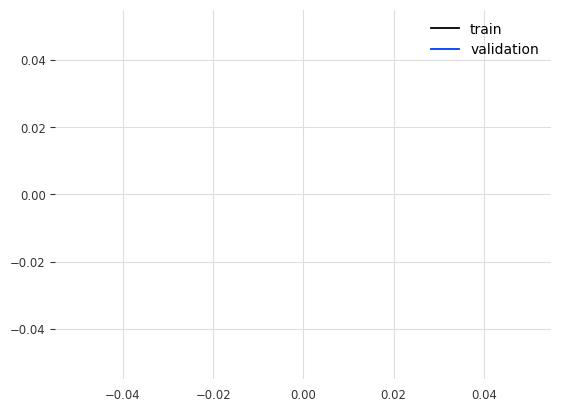

In [27]:
# Afficher la courbe d'apprentissage
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [28]:
# Évaluation du modèle sur les données de test
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss sur les données de test : {loss}')

Loss sur les données de test : nan


In [29]:
# Prédiction sur les données de test
predictions = model.predict(X_test)

65606/65606 [==============================] - 352s 5ms/step


In [30]:
# Inverse transform pour obtenir les prédictions dans l'échelle d'origine
predictions_original_scale = scaler.inverse_transform(predictions)

In [33]:
display(predictions)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

# Regression linéaire

In [126]:
X = train[['store_nbr', 'onpromotion', 'flagHoliday', 'dcoilwtico', 'cluster', 'familyCat',
       'cityCat', 'stateCat', 'typeCat', 'jourCat', 'moisCat',
       'anneeCat', 'jourSemaineCat', 'jourAnneeCat',
       'semaineAnneeCat']]
y = train['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

# Creating a new model and fitting it
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Prediction new values
predictions = multi_model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.20700034005618473
The rmse is:  983.4149666875595


In [127]:
coefs = multi_model.coef_
intercept = multi_model.intercept_
print(coefs)
print(intercept)

[ -0.50785928  38.05725404  33.02581343  -0.32327129   2.52776007
 -10.90218822   3.36361185   6.49364161 -68.67207434   9.83264607
 301.29901945  52.44348674  -1.49393339  -9.33169328   0.53609202]
274.14059430274835


In [128]:
test.sales = test.store_nbr*coefs[0] + test.onpromotion*coefs[1] + test.flagHoliday*coefs[2] + test.dcoilwtico*coefs[3] + test.cluster*coefs[4] + test.familyCat*coefs[5] + test.cityCat*coefs[6] + test.stateCat*coefs[7] + test.typeCat*coefs[8] + test.jourCat*coefs[9] + test.moisCat*coefs[10] + test.anneeCat*coefs[11] + test.jourSemaineCat*coefs[12] + test.jourAnneeCat*coefs[13] + test.semaineAnneeCat*coefs[14]
display(test)

,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2017-08-16,1,0,-53.311452,0,NaN,46.80,13,0,18,12,3,0,0,0,2,0,0
1,2017-08-16,1,0,-64.213640,0,NaN,46.80,13,1,18,12,3,0,0,0,2,0,0
2,2017-08-16,1,2,0.998680,0,NaN,46.80,13,2,18,12,3,0,0,0,2,0,0
3,2017-08-16,1,20,675.127064,0,NaN,46.80,13,3,18,12,3,0,0,0,2,0,0
4,2017-08-16,1,0,-96.920205,0,NaN,46.80,13,4,18,12,3,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,1,-197.984677,0,NaN,47.26,6,28,18,12,1,15,0,0,3,15,2
28508,2017-08-31,9,0,-246.944119,0,NaN,47.26,6,29,18,12,1,15,0,0,3,15,2
28509,2017-08-31,9,1,-219.789053,0,NaN,47.26,6,30,18,12,1,15,0,0,3,15,2
28510,2017-08-31,9,9,73.766791,0,NaN,47.26,6,31,18,12,1,15,0,0,3,15,2


In [129]:
test.sales.mean()

44.78320994887297

In [130]:
test2 = test.copy()

In [131]:
test2.sales = test2.sales.apply(lambda x: max(0, x))

In [132]:
test2.sales.mean()

210.57579637408043

In [133]:
test2.sales = test2.sales.replace(0, np.nan)

In [134]:
test2.sales = test2.sales.interpolate(method='polynomial', order=2)

In [135]:
test2.sales = test2.sales.apply(lambda x: max(0, x))
test2.head(30)

,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2017-08-16,1,0,0.000000,0,NaN,46.8,13,0,18,12,3,0,0,0,2,0,0
1,2017-08-16,1,0,0.000000,0,NaN,46.8,13,1,18,12,3,0,0,0,2,0,0
2,2017-08-16,1,2,0.998680,0,NaN,46.8,13,2,18,12,3,0,0,0,2,0,0
3,2017-08-16,1,20,675.127064,0,NaN,46.8,13,3,18,12,3,0,0,0,2,0,0
4,2017-08-16,1,0,625.447035,0,NaN,46.8,13,4,18,12,3,0,0,0,2,0,0
5,2017-08-16,1,12,348.864656,0,NaN,46.8,13,5,18,12,3,0,0,0,2,0,0
6,2017-08-16,1,0,342.285992,0,NaN,46.8,13,6,18,12,3,0,0,0,2,0,0
7,2017-08-16,1,25,821.804582,0,NaN,46.8,13,7,18,12,3,0,0,0,2,0,0
8,2017-08-16,1,45,1572.047474,0,NaN,46.8,13,8,18,12,3,0,0,0,2,0,0
9,2017-08-16,1,18,533.599427,0,NaN,46.8,13,9,18,12,3,0,0,0,2,0,0


In [136]:
test2['id'] = test2.index + 3000888


In [137]:
display(test2)

,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat,id
0,2017-08-16,1,0,0.000000,0,NaN,46.80,13,0,18,12,3,0,0,0,2,0,0,3000888
1,2017-08-16,1,0,0.000000,0,NaN,46.80,13,1,18,12,3,0,0,0,2,0,0,3000889
2,2017-08-16,1,2,0.998680,0,NaN,46.80,13,2,18,12,3,0,0,0,2,0,0,3000890
3,2017-08-16,1,20,675.127064,0,NaN,46.80,13,3,18,12,3,0,0,0,2,0,0,3000891
4,2017-08-16,1,0,625.447035,0,NaN,46.80,13,4,18,12,3,0,0,0,2,0,0,3000892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,1,0.000000,0,NaN,47.26,6,28,18,12,1,15,0,0,3,15,2,3029395
28508,2017-08-31,9,0,0.000000,0,NaN,47.26,6,29,18,12,1,15,0,0,3,15,2,3029396
28509,2017-08-31,9,1,0.000000,0,NaN,47.26,6,30,18,12,1,15,0,0,3,15,2,3029397
28510,2017-08-31,9,9,73.766791,0,NaN,47.26,6,31,18,12,1,15,0,0,3,15,2,3029398


In [138]:
test3 = test2[['id','sales']]

In [139]:
display(test3)

,id,sales
0,3000888,0.000000
1,3000889,0.000000
2,3000890,0.998680
3,3000891,675.127064
4,3000892,625.447035
...,...,...
28507,3029395,0.000000
28508,3029396,0.000000
28509,3029397,0.000000
28510,3029398,73.766791


In [141]:
test3.to_csv('submission.csv', index=False)


# Régression linéaire multiple

In [146]:
testFinal =  pd.DataFrame(columns=['store_nbr', 'onpromotion', 'flagHoliday', 'dcoilwtico', 'cluster', 'familyCat',
           'cityCat', 'stateCat', 'typeCat', 'jourCat', 'moisCat',
           'anneeCat', 'jourSemaineCat', 'jourAnneeCat',
           'semaineAnneeCat','sales'])

family_unique = train.familyCat.unique()

trainInit = train.copy()
testInit = test.copy()

In [147]:

for i in family_unique:
    train = trainInit[trainInit['familyCat'] == i]

    X = train[['store_nbr', 'onpromotion', 'flagHoliday', 'dcoilwtico', 'cluster', 'familyCat',
           'cityCat', 'stateCat', 'typeCat', 'jourCat', 'moisCat',
           'anneeCat', 'jourSemaineCat', 'jourAnneeCat',
           'semaineAnneeCat']]
    y = train['sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)


    multi_model = LinearRegression()
    multi_model.fit(X_train, y_train)

    test.sales = test.store_nbr*coefs[0] + test.onpromotion*coefs[1] + test.flagHoliday*coefs[2] + test.dcoilwtico*coefs[3] + test.cluster*coefs[4] + test.familyCat*coefs[5] + test.cityCat*coefs[6] + test.stateCat*coefs[7] + test.typeCat*coefs[8] + test.jourCat*coefs[9] + test.moisCat*coefs[10] + test.anneeCat*coefs[11] + test.jourSemaineCat*coefs[12] + test.jourAnneeCat*coefs[13] + test.semaineAnneeCat*coefs[14]
    testFinal = pd.concat([test])



In [149]:
testFinal.sales = testFinal.sales.apply(lambda x: max(0, x))
testFinal.sales = testFinal.sales.replace(0, np.nan)
testFinal.sales = testFinal.sales.interpolate(method='polynomial', order=2)
testFinal.sales = testFinal.sales.apply(lambda x: max(0, x))
testFinal.head(30)

,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2017-08-16,1,0,0.000000,0,NaN,46.8,13,0,18,12,3,0,0,0,2,0,0
1,2017-08-16,1,0,0.000000,0,NaN,46.8,13,1,18,12,3,0,0,0,2,0,0
2,2017-08-16,1,2,0.998680,0,NaN,46.8,13,2,18,12,3,0,0,0,2,0,0
3,2017-08-16,1,20,675.127064,0,NaN,46.8,13,3,18,12,3,0,0,0,2,0,0
4,2017-08-16,1,0,625.447035,0,NaN,46.8,13,4,18,12,3,0,0,0,2,0,0
5,2017-08-16,1,12,348.864656,0,NaN,46.8,13,5,18,12,3,0,0,0,2,0,0
6,2017-08-16,1,0,342.285992,0,NaN,46.8,13,6,18,12,3,0,0,0,2,0,0
7,2017-08-16,1,25,821.804582,0,NaN,46.8,13,7,18,12,3,0,0,0,2,0,0
8,2017-08-16,1,45,1572.047474,0,NaN,46.8,13,8,18,12,3,0,0,0,2,0,0
9,2017-08-16,1,18,533.599427,0,NaN,46.8,13,9,18,12,3,0,0,0,2,0,0


In [148]:
display(testFinal)

,date,store_nbr,onpromotion,sales,flagHoliday,transactions,dcoilwtico,cluster,familyCat,cityCat,stateCat,typeCat,jourCat,moisCat,anneeCat,jourSemaineCat,jourAnneeCat,semaineAnneeCat
0,2017-08-16,1,0,-53.311452,0,NaN,46.80,13,0,18,12,3,0,0,0,2,0,0
1,2017-08-16,1,0,-64.213640,0,NaN,46.80,13,1,18,12,3,0,0,0,2,0,0
2,2017-08-16,1,2,0.998680,0,NaN,46.80,13,2,18,12,3,0,0,0,2,0,0
3,2017-08-16,1,20,675.127064,0,NaN,46.80,13,3,18,12,3,0,0,0,2,0,0
4,2017-08-16,1,0,-96.920205,0,NaN,46.80,13,4,18,12,3,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,1,-197.984677,0,NaN,47.26,6,28,18,12,1,15,0,0,3,15,2
28508,2017-08-31,9,0,-246.944119,0,NaN,47.26,6,29,18,12,1,15,0,0,3,15,2
28509,2017-08-31,9,1,-219.789053,0,NaN,47.26,6,30,18,12,1,15,0,0,3,15,2
28510,2017-08-31,9,9,73.766791,0,NaN,47.26,6,31,18,12,1,15,0,0,3,15,2


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Supposons que votre DataFrame s'appelle df et contient les informations sur les ventes par famille de produit

# Dictionnaire pour stocker les résultats
resultats_par_famille = {}

# Liste des familles de produits uniques
familles_produit_uniques = df['Famille_Produit'].unique()

# Nouveau DataFrame pour stocker les résultats finaux
resultats_finaux = pd.DataFrame(columns=['Date', 'Magasin', 'Famille_Produit', 'Ventes_Volume_Predit'])

# Boucle pour entraîner un modèle par famille de produit
for famille in familles_produit_uniques:
    # Filtrer les données pour la famille de produit spécifique
    data_famille = df[df['Famille_Produit'] == famille]

    # Séparation des variables explicatives et de la variable dépendante
    X = data_famille.drop(['Ventes_Volume'], axis=1)
    y = data_famille['Ventes_Volume']

    # Initialisation du modèle de régression linéaire
    model = LinearRegression()

    # Ajustement du modèle à l'ensemble des données de la famille de produit
    model.fit(X, y)

    # Prédictions sur l'ensemble des données de la famille de produit
    data_famille['Ventes_Volume_Predit'] = model.predict(X)

    # Concaténation des résultats dans le DataFrame final
    resultats_finaux = pd.concat([resultats_finaux, data_famille[['Date', 'Magasin', 'Famille_Produit', 'Ventes_Volume_Predit']]])

# Affichage des premières lignes du DataFrame final
print(resultats_finaux.head())

# Enregistrement du DataFrame final dans un fichier CSV
resultats_finaux.to_csv('resultats_finaux.csv', index=False)




In [145]:
display(len(predictions))

2100622